###  Import the necessary libraries

In [1]:
import csv
import numpy as np
import os
from random import sample
from sklearn.utils import shuffle
import re          
import zipfile     
import pandas as pd 
import tensorflow as tf
from PIL import Image
from torchvision import transforms
from PIL import ImageFile   
import random  

## 1.2 Data preprocessing

In [2]:
df = pd.read_csv('all_data_info_1.csv')

**The code defines a function called 'reduce_dict_random' that takes a dictionary of artists and reduces it to a smaller dictionary with an equal number of items with value 0 and 1, where the values of the input dictionary correspond to the gender of the artists. The function first creates two empty lists called 'zeros' and 'ones', and iterates over the input dictionary, appending the keys with value 0 to 'zeros' and the keys with value 1 to 'ones'. If the number of elements in 'zeros' is greater than 'ones', the function randomly selects len(ones) elements from 'zeros' and stores them back in 'zeros'. The function then creates a new dictionary called 'artists_new' and iterates over the concatenated 'ones' and 'zeros' list, assigning the value of the input dictionary corresponding to the key to 'artists_new'. Finally, the modified dictionary is returned. The purpose of the function is to reduce the size of the input dictionary while maintaining an equal distribution of values, which may be useful in certain machine learning tasks.**

In [ ]:
def reduce_dict_random(artists):  # Define a function called 'reduce_dict_random' that takes a dictionary as input
    zeros = []  # Create an empty list called 'zeros'
    ones = []  # Create an empty list called 'ones'
    for key, value in artists.items():  # Iterate over the items in the input dictionary
        if value == 0:  # If the value is 0, append the key to 'zeros'
            zeros.append(key)
        elif value == 1:  # If the value is 1, append the key to 'ones'
            ones.append(key)
    if len(zeros) > len(ones):  # If the number of elements in 'zeros' is greater than 'ones', 
        zeros = random.sample(zeros, len(ones))  # randomly select len(ones) elements from 'zeros' and store them in 'zeros'
    artists_new = {}  # Create an empty dictionary called 'artists_new'
    for key in ones + zeros:  # Concatenate 'ones' and 'zeros' and iterate over the resulting list
        artists_new[key] = artists[key]  # Assign the value of the input dictionary corresponding to the key to 'artists_new'
    return artists_new                  # Return the modified dictionary

**The code defines a function called split_dict that takes a dictionary, a train fraction, and a test fraction as input. The function shuffles the values of the input dictionary and reassigns them to the keys of the dictionary. Then, it calculates the number of elements in the train, test, and validation sets based on the input fractions. It selects a random subset of keys for the test and validation sets and determines the remaining keys for the train set. The function then creates empty dictionaries for the train, test, and validation sets. It iterates over the keys and values of the input dictionary and adds them to the appropriate set. If the key is in the test set, the function adds it to the test dictionary. If the key is in the validation set, the function adds it to the validation dictionary. Otherwise, the function adds it to the train dictionary. Finally, the function returns the train, test, and validation dictionaries. The function uses the random module to randomly select the keys for the test and validation sets**

In [5]:
import random



def split_dict(data_dict):
    # Get the keys of the original dictionary
    keys = list(data_dict.keys())
    # Randomly shuffle the keys
    random.shuffle(keys)
    # Calculate the number of keys for each split
    num_valid = int(len(keys) * 0.5)
    # Split the keys into two sets
    valid_keys = keys[:num_valid]
    test_keys = keys[num_valid:]
    # Create the new dictionaries
    valid_dict = {k: data_dict[k] for k in valid_keys}
    test_dict = {k: data_dict[k] for k in test_keys}
    # Return the new dictionaries
    return valid_dict, test_dict

**The read_data_info function reads a CSV file located at file_path and returns a dictionary containing information about the artists associated with each image.**

**The function first creates an empty dictionary called artists to hold the artist information. It then opens the CSV file located at file_path using the open function and creates a csv.DictReader object to read the file.**

**The function then iterates over each row of the CSV file using a for loop, and for each row, adds the artist information to the artists dictionary using the new_filename column as the key and the artist column as the value.**

**Finally, the function returns the artists dictionary containing the artist information for each image in the CSV file.**

In [8]:
import csv

def read_data_info(file_path):
    train_artists = {}  # Create an empty dictionary to hold the artist information for rows where is_train is "1"
    test_artists = {}   # Create an empty dictionary to hold the artist information for rows where is_train is "0"
    with open(file_path, encoding='utf-8') as f:  # Open the file at the specified path for reading
        reader = csv.DictReader(f)  # Create a DictReader object to read the CSV file
        for row in reader:  # Iterate over each row of the CSV file
            t = row['in_train']
            if t == 'False':
                test_artists[row['new_filename']] = row['artist']  # Add the artist information to the test_artists dictionary
            else:
                train_artists[row['new_filename']] = row['artist']  # Add the artist information to the train_artists dictionary
                
    return train_artists, test_artists  # Return two dictionaries containing the artist information for rows where is_train is "1" and "0"

**The get_pair_data function that takes three arguments: a dictionary artists, a path to a folder containing image files, and a boolean value is_train (which defaults to True if not specified). The function is designed to generate pairs of image files and their corresponding labels to be used in training or testing a machine learning model.**

**The function first reads the contents of the folder specified by folder_path and stores the filenames in a list called filenames. Then, it loops through each pair of filenames in the list, retrieves the artists' names from the artists dictionary using the filenames as keys, and checks if the two artists' names match. If they do, the pair of filenames is added to a list called pair_filenames, and the label 1 is added to a list called labels. Otherwise, the pair of filenames is added to pair_filenames, and the label 0 is added to labels.**

**After all pairs of filenames and their corresponding labels have been generated, the function checks whether there are more labels with value 0 than 1. If so, the function randomly selects a subset of the labels with value 0 to keep, so that the number of 0s and 1s in the labels are balanced. This is achieved by shuffling the indices of the labels with value 0, selecting a subset of the shuffled indices to keep, and then combining those indices with the indices of the labels with value 1.**

**Finally, the function shuffles the order of the pairs of filenames and their corresponding labels using the shuffle() function from the NumPy library, and returns the shuffled pair of filenames and labels as two separate lists.**

In [10]:
import random
import numpy as np
from sklearn.utils import shuffle

def get_pair_data(artists, folder_path, is_train=True):
    filenames = os.listdir(folder_path)
    pair_filenames = []
    labels = []
    num_ones = 0  # count the number of labels with value 1
    num_zeros = 0  # count the number of labels with value 0
    zero_indices = []  # store the indices of the labels with value 0
    for i, filename1 in enumerate(filenames):
        for j in range(i+1, len(filenames)):
            filename2 = filenames[j]
            artist1 = artists.get(filename1, None)
            artist2 = artists.get(filename2, None)
            if artist1 is not None and artist2 is not None:
                if artist1 == artist2:
                    pair_filenames.append((filename1, filename2))
                    labels.append(1)
                    num_ones += 1
                else:
                    pair_filenames.append((filename1, filename2))
                    labels.append(0)
                    num_zeros += 1
                    zero_indices.append(len(labels) - 1)  # store the index of the newly added label with value 0
    if num_ones / num_zeros < 1.5:
        # Calculate the number of zeros to keep
        num_zeros_to_keep = int(num_ones * 2)  # keep 2 times the number of ones for zeros
        num_zeros_to_keep = min(num_zeros_to_keep, num_zeros)  # cap the number of zeros to keep at the total number of zeros

        # Select the indices of the zeros to keep
        zero_indices_to_keep = random.sample(zero_indices, num_zeros_to_keep)

        # Combine the ones and selected zeros
        pair_filenames = [pair_filenames[i] for i in zero_indices_to_keep] + [pair_filenames[i] for i, label in enumerate(labels) if label == 1]
        labels = [0] * num_zeros_to_keep + [1] * num_ones

    # Ensure the number of elements in pair_filenames and labels are the same
    assert len(pair_filenames) == len(labels), "Number of elements in pair_filenames and labels are different"
    
    # Shuffle the data
    pair_filenames, labels = shuffle(np.array(pair_filenames), np.array(labels))
    return list(pair_filenames), list(labels)


**preprocess_image** function takes an image file path as input and performs a series of pre-processing steps on it to prepare it for use in a VGG16 model for image classification. Here is a line-by-line explanation of what the function does:

* image = tf.io.read_file(image_path): reads the image file from the provided file path.
* image = tf.image.decode_image(image,channels=3): decodes the image to a tensor and makes sure it has three color channels (red, green, and blue).
* image = tf.image.central_crop(image, 0.5): crops the center half of the image.
* image = tf.image.resize(image, (224,224)): resizes the image to (224, 224), which is the size required by the VGG16 model.
* image = tf.keras.applications.vgg16.preprocess_input(image): performs pre-processing required by the VGG16 model on the image, such as subtracting the mean pixel value for each channel and converting the color channels from RGB to BGR.

**The function then returns the pre-processed image tensor.**

In [11]:
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image,channels=3)
    if image.shape[0] < 3:
        image = tf.tile(tf.expand_dims(image, axis=2), [1, 1, 3])
    if image.shape[0] > 3:
        image = image[:,:,0:3]
    #image = tf.image.central_crop(image, 0.5)
    image = tf.image.resize(image, (224,224))
    image = tf.keras.applications.vgg16.preprocess_input(image)
    return image

**data_generator** function is a generator that yields batches of image pairs and their corresponding labels for training a siamese neural network.

It takes in the following arguments:

* artists: a dictionary containing the artist labels for each image file
* folder_path: the path to the folder containing the image files
* batch_size: the number of pairs of images to include in each batch
* is_train: a boolean indicating whether to generate data for training or testing

**First, it calls the get_pair_data function to retrieve pairs of image filenames and their corresponding labels. Then, in an infinite loop, it iterates through the pairs and yields batches of size batch_size. For each batch, it retrieves the image files, preprocesses them using the preprocess_image function, and appends them to the batch_images_a and batch_images_b lists. It then yields a tuple containing the two lists of preprocessed images and their corresponding labels.**





In [12]:
def data_generator(artists, folder_path, batch_size, is_train=True):
    pair_filenames, labels = get_pair_data(artists, folder_path, is_train)
    while True:
        for i in range(0, len(pair_filenames), batch_size):
            batch_pair_filenames = pair_filenames[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            batch_images_a = []
            batch_images_b = []
            for (filename1, filename2) in batch_pair_filenames:
                image_path1 = os.path.join(folder_path, filename1)
                image_path2 = os.path.join(folder_path, filename2)
                batch_images_a.append(preprocess_image(image_path1))
                batch_images_b.append(preprocess_image(image_path2))
            yield [np.array(batch_images_a), np.array(batch_images_b)], np.array(batch_labels)

In [13]:
"""
Reads the artist data information from 'all_data_info.csv' file and creates a
dictionary of artist name and their corresponding filenames, 
""" 
train_artists, test_artists = read_data_info('all_data_info_1.csv')
valid_dict,test_dict = split_dict(test_artists)

keys = random.sample(valid_dict.keys(), 5000)
valid_dictt = {k: valid_dict[k] for k in keys}

keys = random.sample(test_dict.keys(), 5000)
test_dictt = {k: test_dict[k] for k in keys}
"""
then splits the dictionary into train, test, and validation dictionaries with a 60-40 ratio.
Then defines the batch size as 32 and creates data generators for train, test, and validation datasets 
using the split dictionaries and the 'data_generator' function,
which yields preprocessed image pairs and their corresponding labels in batches.
"""

C:\Users\YASSIN\AppData\Local\Temp\ipykernel_7672\38888826.py:8: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  keys = random.sample(valid_dict.keys(), 5000)
C:\Users\YASSIN\AppData\Local\Temp\ipykernel_7672\38888826.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  keys = random.sample(test_dict.keys(), 5000)


"\nthen splits the dictionary into train, test, and validation dictionaries with a 60-40 ratio.\nThen defines the batch size as 32 and creates data generators for train, test, and validation datasets \nusing the split dictionaries and the 'data_generator' function,\nwhich yields preprocessed image pairs and their corresponding labels in batches.\n"

In [14]:
batch = 32
train_data_generator = data_generator(train_artists, 'train/train_crop', batch, is_train=True)
test_data_generator  = data_generator(test_dictt, 'test/test_crop', batch, is_train=False)
val_data_generator   = data_generator(valid_dictt, 'test/test_crop', batch, is_train=False)

In [15]:
#get artist name by filename
def get_artist(idd):
    return df[df.new_filename==idd].artist

train/train_crop/20563.jpg
train/train_crop/28529.jpg
train/train_crop/24579.jpg
train/train_crop/29560.jpg
train/train_crop/24364.jpg
train/train_crop/24830.jpg
train/train_crop/29441.jpg
train/train_crop/29749.jpg
train/train_crop/2329.jpg
train/train_crop/29738.jpg


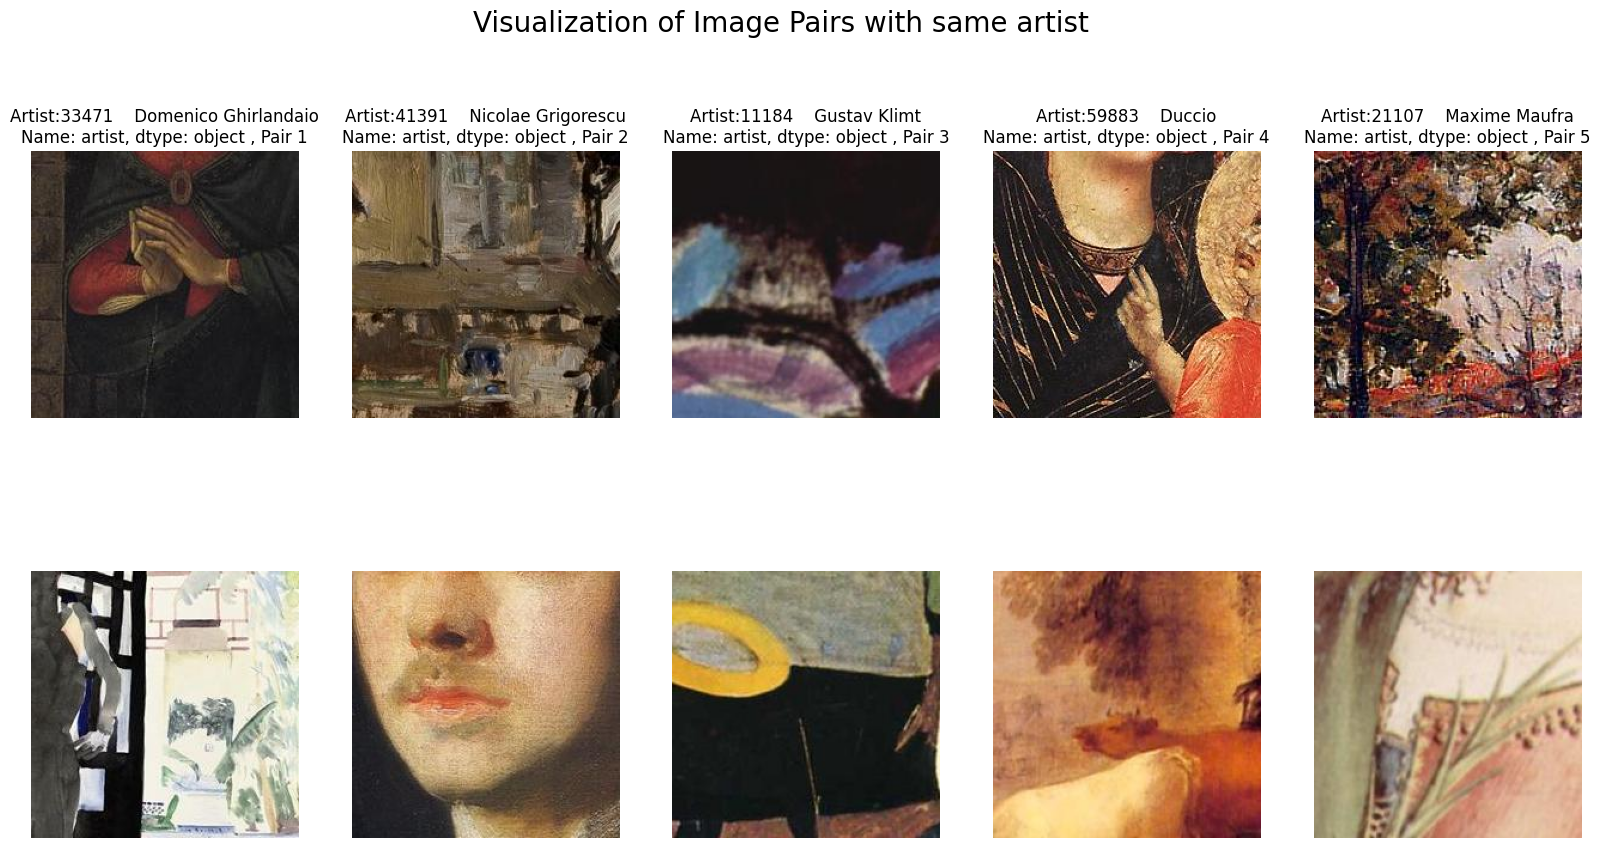

In [16]:
import matplotlib.pyplot as plt
import random
pair_filenames, labels = get_pair_data(train_artists, 'train/train_crop', True)
# Create empty lists for class 0 and class 1 image pairs
class0_pairs = []
class1_pairs = []

# Iterate over pairs and labels simultaneously to separate pairs by class
for i, label in enumerate(labels):
    if label == 0:
        class0_pairs.append(pair_filenames[i])
    else:
        class1_pairs.append(pair_filenames[i])

# Create a figure with subplots for each class
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
fig.suptitle('Visualization of Image Pairs with same artist', fontsize=20)

# Visualize 5 pairs from class 0
for i in range(5):
    img_pair = random.choice(class0_pairs)
    img1 = plt.imread("train/train_crop/"+img_pair[0])
    img2 = plt.imread("train/train_crop/"+img_pair[1])
    print("train/train_crop/"+img_pair[0])
    print("train/train_crop/"+img_pair[1])
    axs[0, i].imshow(img1)
    axs[0, i].set_title(f'Artist:{get_artist(img_pair[0])} , Pair {i+1}')
    axs[0, i].axis('off')
    axs[1, i].imshow(img2)
    axs[1, i].axis('off')
# Show the plot
plt.show()

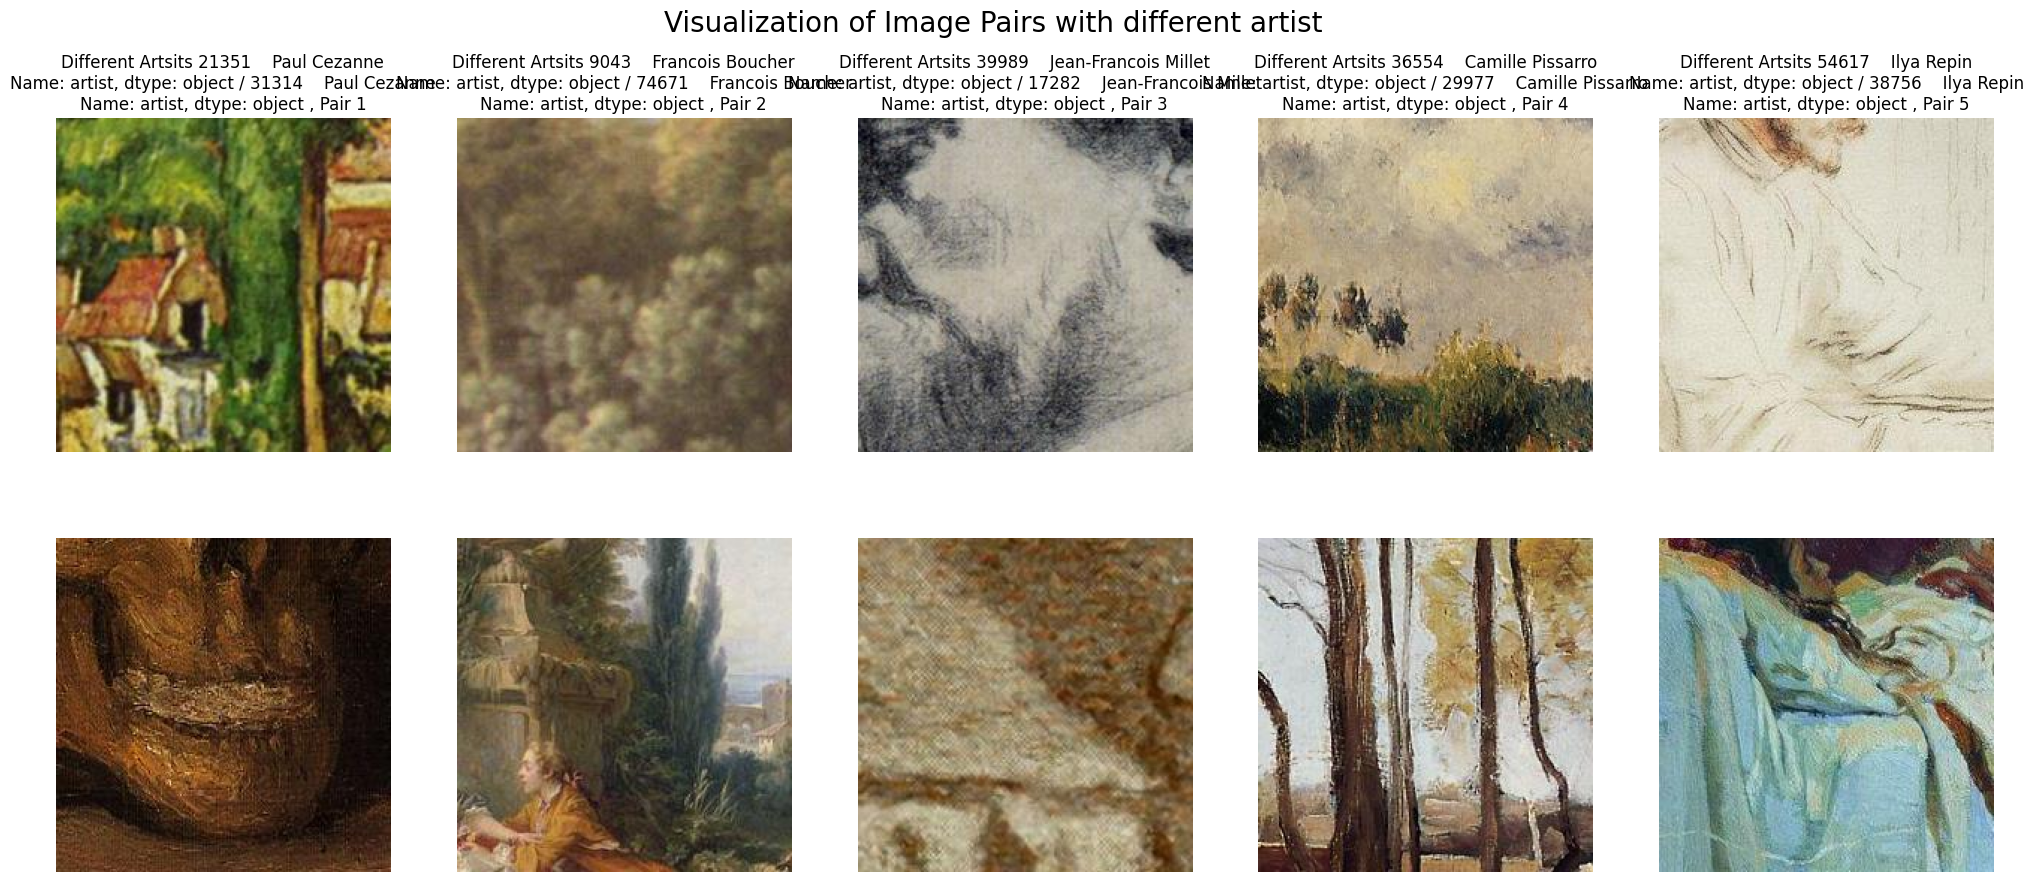

In [17]:
# Create a figure with subplots for each class
fig, axs = plt.subplots(2, 5, figsize=(25, 10))
fig.suptitle('Visualization of Image Pairs with different artist', fontsize=20)

# Visualize 5 pairs from class 0
for i in range(5):
    img_pair = random.choice(class1_pairs)
    img1 = plt.imread("train/train_crop/"+img_pair[0])
    img2 = plt.imread("train/train_crop/"+img_pair[1])
    axs[0, i].imshow(img1)
    axs[0, i].set_title(f'Different Artsits {get_artist(img_pair[0])} / {get_artist(img_pair[1])} , Pair {i+1}')
    axs[0, i].axis('off')
    axs[1, i].imshow(img2)
    axs[1, i].axis('off')
# Show the plot
plt.show()

# Model training

**This is a Siamese neural network architecture implemented in TensorFlow. It takes two inputs, input_a and input_b, each with a shape of (224,224,3). These two inputs are fed through a pre-trained VGG16 convolutional neural network, which has the weights pre-trained on the ImageNet dataset. The VGG16 model is not trainable in this case as its pre-trained weights are being used.**

**The output of the VGG16 model for both input_a and input_b is then fed into a Lambda layer, where the absolute difference between the two outputs is calculated. This output is then flattened and passed through a Dense layer with a sigmoid activation function to obtain a binary prediction (0 or 1) indicating whether the two input images are of the same artist or not.**

**The model is compiled with binary cross-entropy loss and the Adam optimizer. It also has accuracy as a metric. An EarlyStopping callback is defined to monitor the validation accuracy and stop training if the accuracy doesn't improve after 10 epochs. The model is trained using the fit method with a training data generator, a validation data generator, and 150 epochs. The training will stop earlier if the EarlyStopping criterion is met. The summary of the model is printed at the end.**

In [19]:
input_a = tf.keras.layers.Input(shape=(224,224,3))

input_b = tf.keras.layers.Input(shape=(224,224,3))

model = tf.keras.applications.resnet.ResNet101(weights='imagenet', include_top=False, input_shape=(224,224,3))

model.trainable = False

encoded_a  = model(input_a)

encoded_b  = model(input_b)


distance   = tf.keras.layers.Lambda(lambda x: tf.keras.backend.abs(x[0] - x[1]))([encoded_a, encoded_b])


pooled = tf.keras.layers.GlobalMaxPooling2D()(distance)

flattened = tf.keras.layers.Dropout(0.1)(pooled)

prediction = tf.keras.layers.Dense(1, activation='sigmoid', use_bias=False)(flattened)

siamese_net = tf.keras.Model(inputs=[input_a, input_b], outputs=prediction)

siamese_net.compile(loss='binary_crossentropy', 
                    optimizer=tf.keras.optimizers.RMSprop(lr=0.0001)
                    , metrics=['accuracy'])

siamese_net.summary()

from tensorflow.keras.callbacks import EarlyStopping



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet101 (Functional)         (None, 7, 7, 2048)   42658176    ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

C:\Users\YASSIN\.conda\envs\tensorflow\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [20]:
#Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='min', verbose=1)
 
# Train the model with early stopping
h = siamese_net.fit(train_data_generator, epochs=20, steps_per_epoch=len(train_artists)//batch,
               validation_data=val_data_generator, validation_steps=len(valid_dictt)//batch,
                verbose=1,callbacks=[early_stopping])

Epoch 1/20
2482/2482 [==============================] - 1449s 577ms/step - loss: 2.0024 - accuracy: 0.5883 - val_loss: 1.4117 - val_accuracy: 0.6312
Epoch 2/20
2482/2482 [==============================] - 1347s 543ms/step - loss: 1.3665 - accuracy: 0.6065 - val_loss: 1.0620 - val_accuracy: 0.5765
Epoch 3/20
2482/2482 [==============================] - 1360s 548ms/step - loss: 1.0154 - accuracy: 0.6221 - val_loss: 0.8470 - val_accuracy: 0.6352
Epoch 4/20
2482/2482 [==============================] - 1363s 549ms/step - loss: 0.8087 - accuracy: 0.6425 - val_loss: 0.6959 - val_accuracy: 0.6472
Epoch 5/20
2482/2482 [==============================] - 1369s 552ms/step - loss: 0.7066 - accuracy: 0.6520 - val_loss: 0.6498 - val_accuracy: 0.6619
Epoch 6/20
2482/2482 [==============================] - 1351s 545ms/step - loss: 0.6576 - accuracy: 0.6656 - val_loss: 0.6386 - val_accuracy: 0.6494
Epoch 7/20
2482/2482 [==============================] - 1364s 549ms/step - loss: 0.6355 - accuracy: 0.6696

## Train and Test validation error / accuracy

**This code is used to plot the training and validation accuracy and loss of a deep learning model. The accuracy plot shows the performance of the model on the training and validation data over the epochs. The loss plot shows how the loss function changes during the training process. The plot helps to evaluate the model's performance and identify if there is any overfitting or underfitting in the model. Overfitting occurs when the model performs well on the training data but poorly on the validation data. Underfitting, on the other hand, occurs when the model doesn't perform well on either training or validation data**

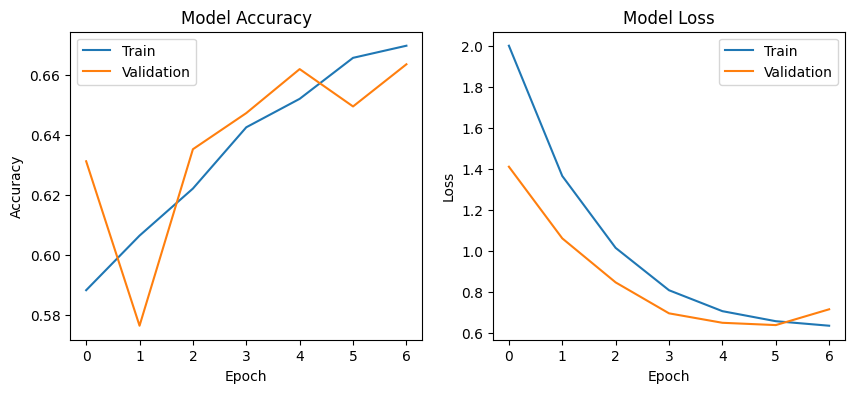

In [27]:
# Plot the train/validation accuracy and loss on a subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(h.history['accuracy'], label='Train')
ax1.plot(h.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(h.history['loss'], label='Train')
ax2.plot(h.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
plt.show()

### Save model

In [28]:
siamese_net.save('models_1')

INFO:tensorflow:Assets written to: models_1\assets


INFO:tensorflow:Assets written to: models_1\assets


### New predictions

In [3]:
import tensorflow as tf
from PIL import Image
import os
import numpy as np

def predict_similarity(image_path_1, image_path_2, model):
    # Load and crop images
    target_size = (224, 224)
    image1 = Image.open(image_path_1)
    width, height = image1.size
    left = (width - target_size[0]) / 2
    top = (height - target_size[1]) / 2
    right = (width + target_size[0]) / 2
    bottom = (height + target_size[1]) / 2
    image1 = image1.crop((left, top, right, bottom))
    image2 = Image.open(image_path_2)
    width, height = image2.size
    left = (width - target_size[0]) / 2
    top = (height - target_size[1]) / 2
    right = (width + target_size[0]) / 2
    bottom = (height + target_size[1]) / 2
    image2 = image2.crop((left, top, right, bottom))

    # Preprocess images
    image1 = tf.image.resize(np.array(image1), (224,224))
    image1 = tf.keras.applications.resnet_v2.preprocess_input(image1)
    image2 = tf.image.resize(np.array(image2), (224,224))
    image2 = tf.keras.applications.resnet_v2.preprocess_input(image2)

    # Make prediction
    prediction = model.predict([tf.expand_dims(image1, axis=0), tf.expand_dims(image2, axis=0)])
    return prediction[0][0]

In [1]:
# Load trained model
import tensorflow as tf
model = tf.keras.models.load_model('models')

In [31]:
# Evaluate the model on the test data generator
test_scores = model.evaluate_generator(test_data_generator, steps=1000)

C:\Users\YASSIN\AppData\Local\Temp\ipykernel_7672\1989614566.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_scores = model.evaluate_generator(test_data_generator, steps=1000)


In [6]:
# Make prediction for two images
similarity = predict_similarity('train/train_2/24317.jpg', 'train/train_2/27357.jpg', model)
# Check if the images are similar (1) or dissimilar (0)
if similarity >= 0.4:
    print('The images are  from same artist')
else:
    print('The images are not from same artist')

1/1 [==============================] - 0s 45ms/step
The images are  from same artist
